<a href="https://colab.research.google.com/github/ferjorosa/learn-fastai/blob/main/mnist_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST example

## Imports

In [1]:
#hide (Google Colab)
!pip install fastai --upgrade -q
import fastai
print(fastai.__version__)

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 189 kB 4.3 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
2.5.3
     |████████████████████████████████| 720 kB 4.1 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 1.2 MB 30.3 MB/s 
     |████████████████████████████████| 51 kB 320 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Data

In [3]:
path = untar_data(URLs.MNIST)

zeros = (path/"training"/"0").ls().sorted()
ones = (path/"training"/"1").ls().sorted()
twos = (path/"training"/"2").ls().sorted()
threes = (path/"training"/"3").ls().sorted()
fours = (path/"training"/"4").ls().sorted()
fives = (path/"training"/"5").ls().sorted()
sixes = (path/"training"/"6").ls().sorted()
sevens = (path/"training"/"7").ls().sorted()
eights = (path/"training"/"8").ls().sorted()
nines = (path/"training"/"9").ls().sorted()

In [4]:
zero_tensors = [tensor(Image.open(o)) for o in zeros]
one_tensors = [tensor(Image.open(o)) for o in ones]
two_tensors = [tensor(Image.open(o)) for o in twos]
three_tensors = [tensor(Image.open(o)) for o in threes]
four_tensors = [tensor(Image.open(o)) for o in fours]
five_tensors = [tensor(Image.open(o)) for o in fives]
six_tensors = [tensor(Image.open(o)) for o in sixes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
eight_tensors = [tensor(Image.open(o)) for o in eights]
nine_tensors = [tensor(Image.open(o)) for o in nines]

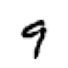

In [5]:
show_image(nine_tensors[2])

In [6]:
nine_tensors[0].shape[0]

28

In [7]:
img_dim = nine_tensors[0].shape[0]**2

stacked_zeros = torch.stack(zero_tensors).view(-1, img_dim).float()/255
stacked_ones = torch.stack(one_tensors).view(-1, img_dim).float()/255
stacked_twos = torch.stack(two_tensors).view(-1, img_dim).float()/255
stacked_threes = torch.stack(three_tensors).view(-1, img_dim).float()/255
stacked_fours = torch.stack(four_tensors).view(-1, img_dim).float()/255
stacked_fives = torch.stack(five_tensors).view(-1, img_dim).float()/255
stacked_sixes = torch.stack(six_tensors).view(-1, img_dim).float()/255
stacked_sevens = torch.stack(seven_tensors).view(-1, img_dim).float()/255
stacked_eights = torch.stack(eight_tensors).view(-1, img_dim).float()/255
stacked_nines = torch.stack(nine_tensors).view(-1, img_dim).float()/255

stacked_eights.shape

torch.Size([5851, 784])

In [55]:
data_x =torch.cat([stacked_zeros, 
                   stacked_ones,
                   stacked_twos, 
                   stacked_threes,
                   stacked_fours,
                   stacked_fives,
                   stacked_sixes,
                   stacked_sevens,
                   stacked_eights,
                   stacked_nines])

data_y = torch.cat([torch.tensor([0] * len(stacked_zeros)), 
                    torch.tensor([1] * len(stacked_ones)),
                    torch.tensor([2] * len(stacked_twos)),
                    torch.tensor([3] * len(stacked_threes)),
                    torch.tensor([4] * len(stacked_fours)),
                    torch.tensor([5] * len(stacked_fives)),
                    torch.tensor([6] * len(stacked_sixes)),
                    torch.tensor([7] * len(stacked_sevens)),
                    torch.tensor([8] * len(stacked_eights)),
                    torch.tensor([9] * len(stacked_nines))])#.unsqueeze(1)

(data_x.shape, data_y.shape)

(torch.Size([60000, 784]), torch.Size([60000]))

**Note on unsqueeze(1).** In the "basic_mnist_example", we used a dimension of [60000, 1] that was obtained by using unsqueeze. However, when using softmax, this has resulted in issues...

#### Divide training data into "train" and "validation"

In order to do it we are going to sample (without replacement) a number of integer values from 0 to 60000. Then select those data instances as the validation data, and the rest of data instances as the training data.


In [56]:
n_data = data_x.shape[0]
n_valid = 5000

valid_indices = np.random.choice(n_data, n_val, replace=False)
valid_mask = np.zeros(n_data, bool)
valid_mask[valid_indices] = True

valid_data_x = data_x[valid_mask]
valid_data_y = data_y[valid_mask]

train_data_x = data_x[~valid_mask]
train_data_y = data_y[~valid_mask]

print(train_data_x.shape, valid_data_x.shape)
print(train_data_y.shape, valid_data_y.shape)

torch.Size([55000, 784]) torch.Size([5000, 784])
torch.Size([55000]) torch.Size([5000])


#### Create the DataLoaders object that will be used in training

In [57]:
train_dset = list(zip(train_data_x, train_data_y))
valid_dset = list(zip(valid_data_x, valid_data_y))

In [58]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
xb, yb = first(train_dl)
print(xb.shape, yb.shape)

valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)
xb, yb = first(valid_dl)
print(xb.shape, yb.shape)

torch.Size([256, 784]) torch.Size([256])
torch.Size([256, 784]) torch.Size([256])


## Model training

#### Cross-entropy loss

When using the cross-entropy loss, it is not necessary that we establish a softmax layer in the model because it will be implicitly called by Pytorch.

In [118]:
from fastai.metrics import accuracy

lr = 1e-3
dls = DataLoaders(train_dl, valid_dl)

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10)
    )

learner = Learner(dls, simple_net, opt_func=SGD, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learner.fit(15, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.278609,2.268405,0.142800,00:01
1,2.245329,2.234315,0.179600,00:01
2,2.207269,2.195868,0.219000,00:01
3,2.164123,2.153165,0.288800,00:01
4,2.118580,2.107271,0.386800,00:00
5,2.069594,2.058478,0.470600,00:00
6,2.018282,2.006596,0.536800,00:00
7,1.963612,1.951448,0.597400,00:01
8,1.906140,1.892800,0.638400,00:01
9,1.841475,1.830657,0.674400,00:01


#### Negative log-likelihood loss

When using the NLL loss, it is necessarty that we establish a LogSoftmax layer at the end of the model.

In [120]:
from fastai.metrics import accuracy

lr = 1e-3
dls = DataLoaders(train_dl, valid_dl)

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10),
    nn.LogSoftmax(dim=1)
    )

learner = Learner(dls, simple_net, opt_func=SGD, loss_func=nn.NLLLoss(), metrics=accuracy)
learner.fit(15, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.289681,2.283192,0.111000,00:00
1,2.244555,2.238252,0.206600,00:01
2,2.200183,2.193497,0.312400,00:01
3,2.155073,2.146981,0.402000,00:00
4,2.106976,2.098569,0.465600,00:00
5,2.057147,2.048184,0.499800,00:01
6,2.005883,1.995157,0.529200,00:01
7,1.952490,1.939616,0.549200,00:01
8,1.894895,1.881997,0.564000,00:01
9,1.835598,1.822580,0.577200,00:01


## Model interpretation

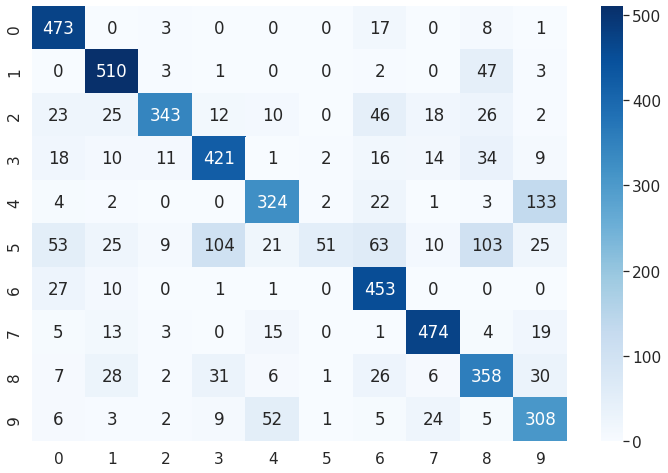

In [119]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

preds,targs = learner.get_preds()
preds,y = learner.get_preds()
y_pred = torch.softmax(preds, dim=1)
y_pred = torch.argmax(y_pred, dim=1)
conf_matrix = confusion_matrix(y.numpy(), y_pred.numpy())

# Set Figure
fig = plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g')

plt.show()